<a href="https://colab.research.google.com/github/Rodrigomoreira-bd/credit_score_python_machine_learning/blob/main/CreditScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Análise de Risco de Crédito com Machine Learning**

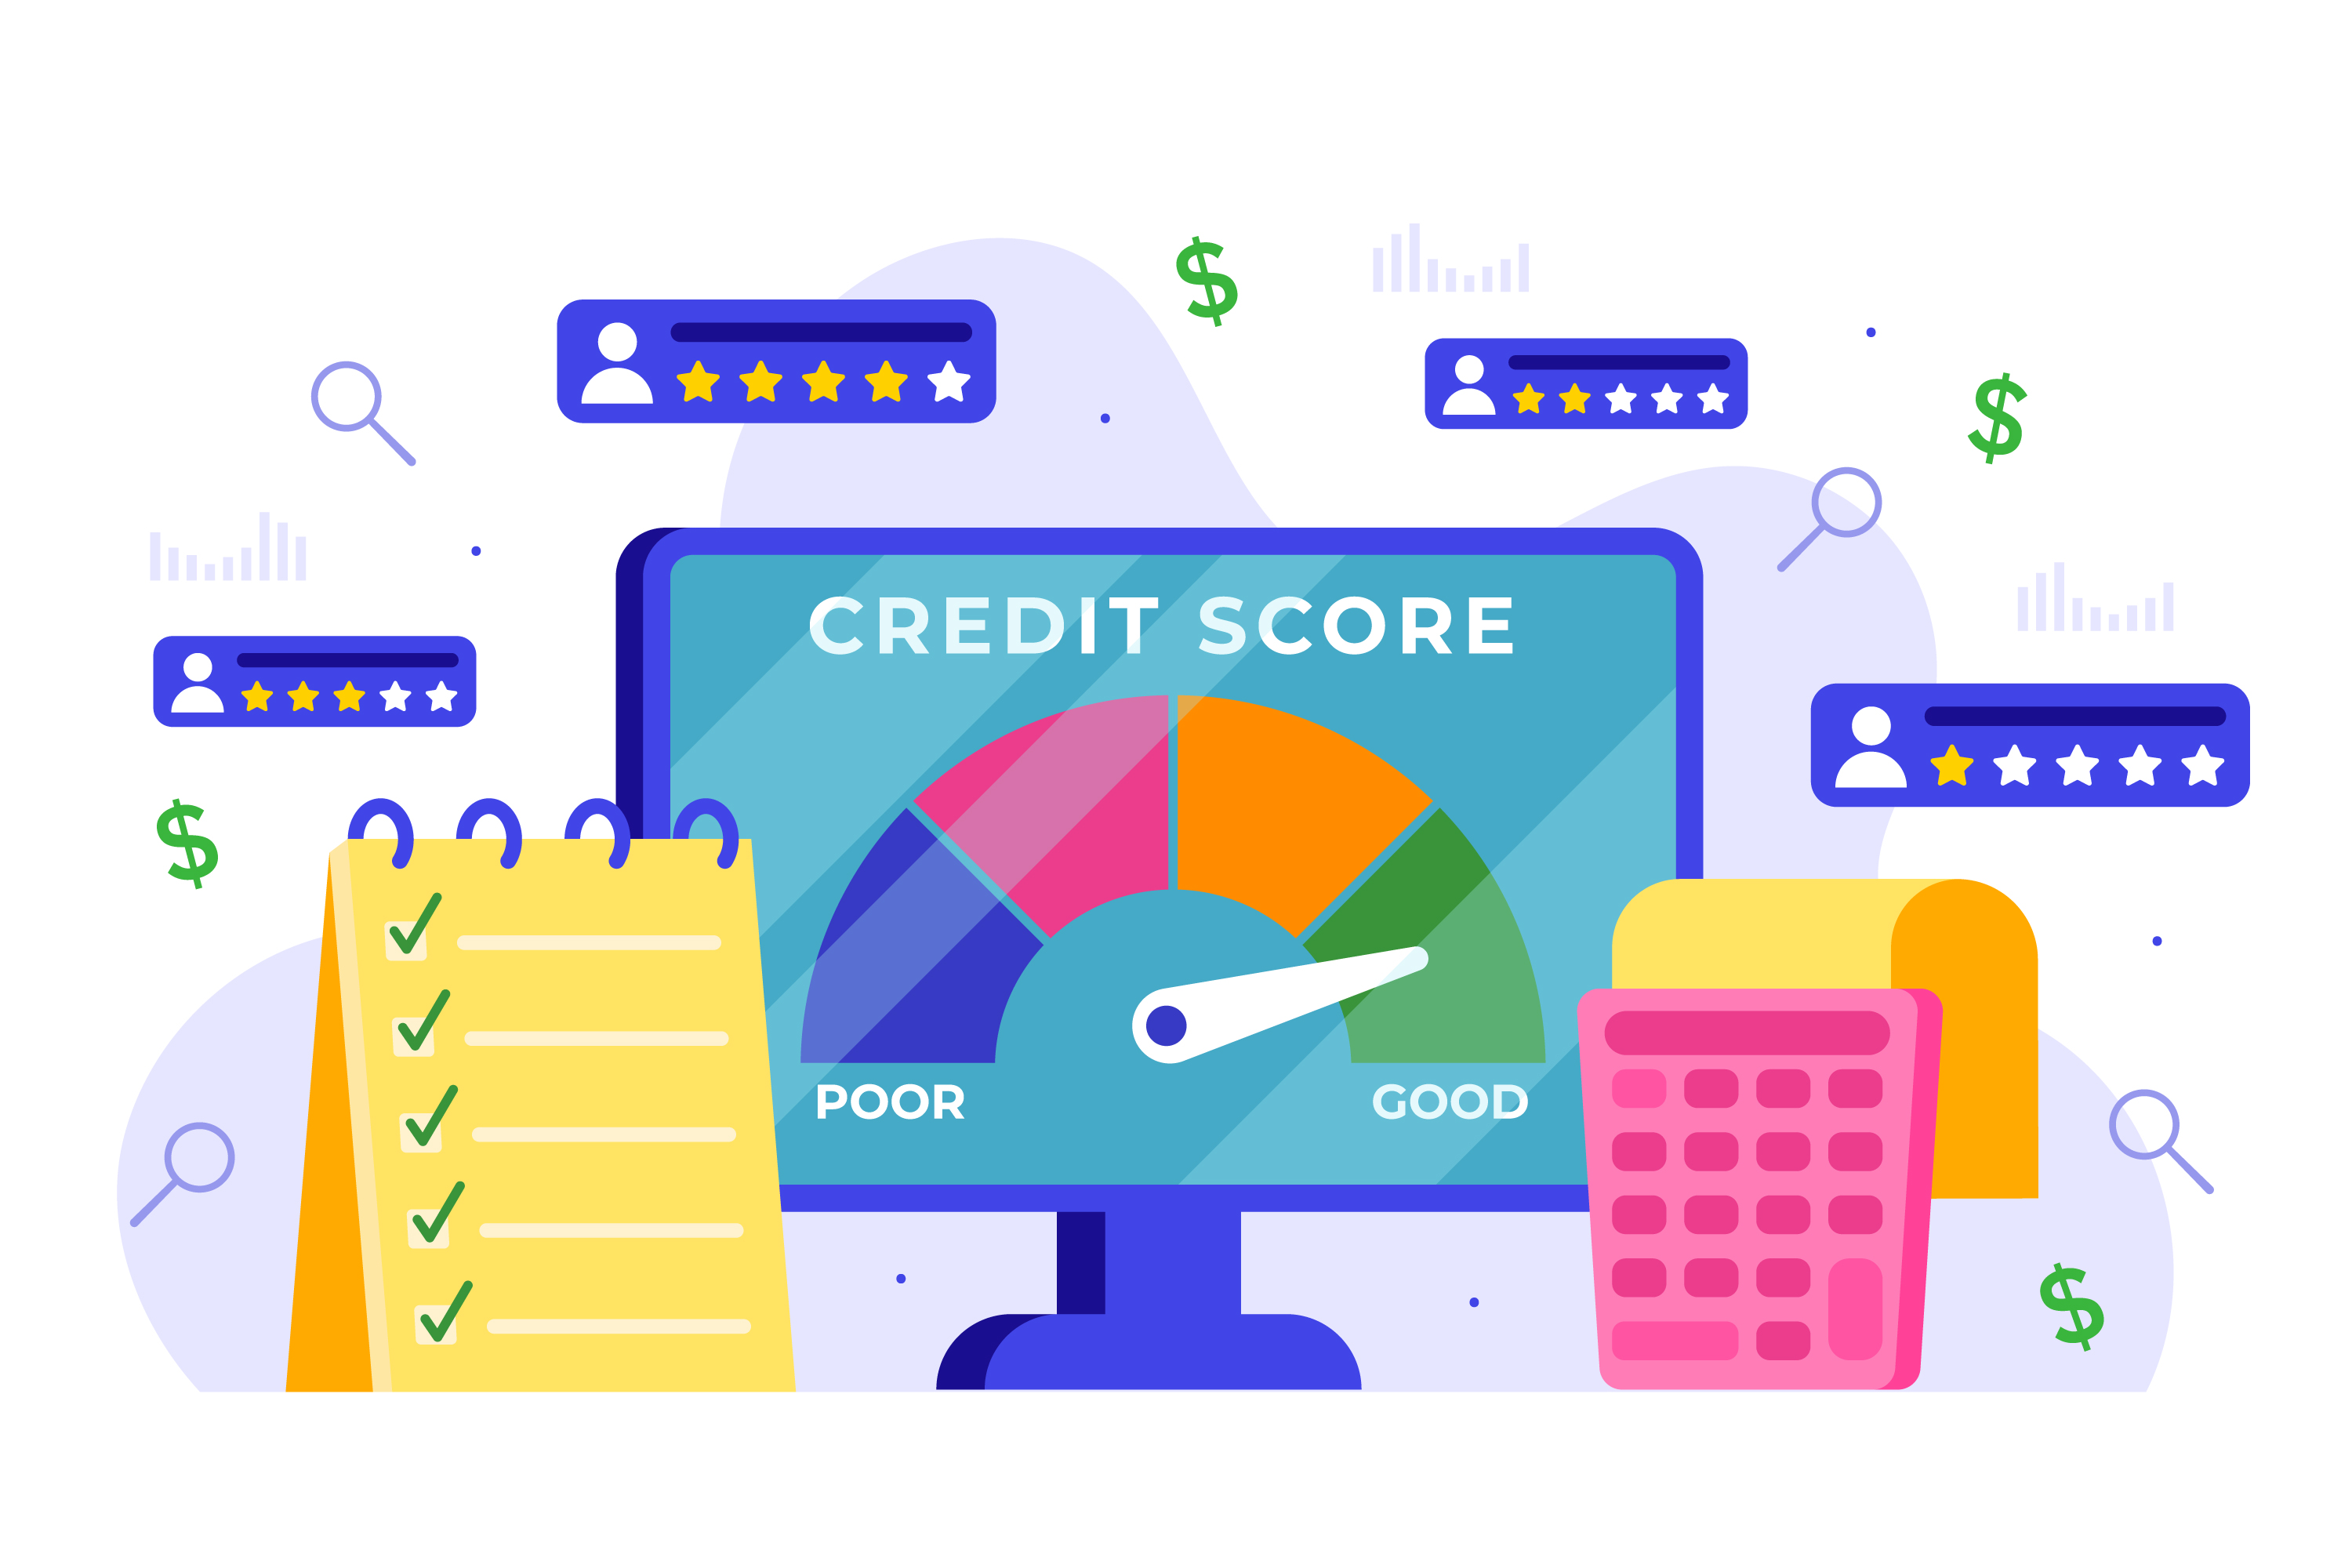

<a href='https://br.freepik.com/fotos-vetores-gratis/cartao-de-credito'>Cartão de crédito vetor criado por freepik - br.freepik.com</a>

O objetivo desse modelo é apresentar uma solução utilizando machine learning capaz de gerar score de crédito com base em dados passados dos clientes.

O Score de Crédito, é o resultado de um cálculo estatístico (Regressão Logística) que tem por objetivo ajudar os consumidores e as empresas a realizarem negócios com crédito, com menor custo e maior agilidade.

(O que é geração de score na análise de crédito? - A Ibratan https://www.ibratan.com.br)

A regressão logística é um modelo estatístico usado para determinar a probabilidade de um evento acontecer. Ele mostra a relação entre os recursos e, em seguida, calcula a probabilidade de um determinado resultado. A regressão logística é usada no aprendizado de máquina (ML) para ajudar a criar previsões precisas. (O que é regressão logística? | TIBCO Software https://www.tibco.com › pt-br › what-is-logistic-regression)


O modelo apresentado utiliza como base o Framework crisp-DM.
Criado em 1996, CRISP-DM (veja a documentação: https://github.com/Rodrigomoreira-bd/credit_score_python_machine_learning) consiste em um conjunto de boas práticas (aka metodologia) para se executar um projeto em Ciência de Dados, ou nos dias de hoje, popularmente chamado de Data Science.
(https://dnc.group/blog/data-science/metodologia-crisp-dm/)




#**Conhecendo o Dataset**

Começaremos configurando o notebook em google colab importando a biblioteca pandas e configurando a chamada do dataset em CSV que está em um repositório privado no google drive.

In [1]:
#Intalação do Pandas Profilling: https://github.com/pandas-profiling/pandas-profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

#Instalação do optbinning: http://gnpalencia.org/optbinning/installation.html
!pip install optbinning

#Instalação de módulo: https://pypi.org/project/dython/
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#configurando o notebook
import pandas as pd
import scipy.stats as ss
import statsmodels.api as sm #Módulo statsmodels: https://www.statsmodels.org/stable/index.html
import pickle
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from optbinning import OptimalBinning
from optbinning import BinningProcess
from dython import nominal
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#carregamento dos dados
df = pd.read_csv('/content/drive/MyDrive/projeto_creditscore/Curso/aula3/dataset_trat.csv',sep=';')
df.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,200510,20000,2,2,1,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,200510,120000,2,2,2,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,200510,90000,2,2,2,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,200510,50000,2,2,1,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,200510,50000,1,2,1,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#**Dicionário de Dados**

Vamos entender melhor as variáveis presentes no dataframe (Veja a documentação: https://github.com/Rodrigomoreira-bd/credit_score_python_machine_learning).


ID: id atribuído a solicitação do cliente.

SAFRA: Mês em que o cliente fez a solicitação de crédito.

LIMIT BAL: Valor do Crédito concedido ao cliente.

SEX:  Gênero do cliente.

EDUCATION: Escolaridade do cliente.

MARRIAGE: Estado civil.

AGE: Idade do cliente.

PAY_0 - PAY_6: Histórico de pagamentos de Abril a Setembro da seguinte forma: PAY_0 (SETEMBRO)...PAY_6 (Abril).

BILL_AMT1 - BILL_AMT6: Valor do extrato da conta de Abril a Setembro da seguinte forma: BILL_AMT1 (SETEMBRO)...BILL_AMT6 (ABRIL).

PAY_AMT1 - PAY_AMT6: Valor do pagamento anterior de Abril a Setembro da seguinte forma: PAY_AMT1 (SETEMBRO)...PAY_AMT6 (ABRIL).

default: variável binária indica se realizou pagamento ou não (Variável Target).


#**Transformações**

Criaremos 3 variáveis com a média a soma e o valor máximo de pagamentos e dívidas do cliente nos último 6 meses.

In [4]:
#soma do valor das faturas nos últimos 6 meses.
df['SUM_BILL'] = df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']

#média das faturas no últimos 6 meses.
df['AVG_BILL'] = df['SUM_BILL'] / 6

#valor máximo de endividamento do cliente nos últimos 6 meses
df['MAX_BILL'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].max(axis=1)


#soma dos pagamentos nos últimos 6 meses.
df['SUM_PAY'] = df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6']

#média dos pagamentos nos últimos 6 meses.
df['AVG_PAY'] = df['SUM_PAY'] / 6

#valor máximo pago pelo cliente nos últimos 6 meses (tentando estimar a capacidade de pagamento do cliente)
df['MAX_PAY'] = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].max(axis=1)

#Utilizaremos o metodo head() para verificar a criação das novas variáveis, agora o dataframe tem 32 colunas
df.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,SUM_BILL,AVG_BILL,MAX_BILL,SUM_PAY,AVG_PAY,MAX_PAY
0,1,200510,20000,2,2,1,24,2,2,-1,...,0,0,0,1,7704,1284.000000,3913,689,114.833333,689
1,2,200510,120000,2,2,2,26,-1,2,0,...,1000,0,2000,1,17077,2846.166667,3455,5000,833.333333,2000
2,3,200510,90000,2,2,2,34,0,0,0,...,1000,1000,5000,0,101653,16942.166667,29239,11018,1836.333333,5000
3,4,200510,50000,2,2,1,37,0,0,0,...,1100,1069,1000,0,231334,38555.666667,49291,8388,1398.000000,2019
4,5,200510,50000,1,2,1,57,-1,0,-1,...,9000,689,679,0,109339,18223.166667,35835,59049,9841.500000,36681


#**Divisão do Conjunto de Dados**

Como boas Práticas dividiremos o nosso conjunto de dados inicial em 3 partes:



1.  Treino = Usamos essa parte para ajustar o modelo (70%)
1.  Teste = Usamos essa parte para fazer comparações com o modelo de treino (30%)
2.  Validação = Após os testes e ajustes realizados usamos essa parte para validar e corrigir possíveis anomalias. Usaremos as safras 200605, 200606 e 200607 para fazer essa validação e chamaremos de "OOT".

In [5]:
#00T = Safras acima 05/2006
oot = df.loc[df['SAFRA'] >= 200605]

#visualizando a volumetria das safras acima de 05/2006
oot['SAFRA'].groupby(oot['SAFRA']).count()

SAFRA
200605    3000
200606    3000
200607    3000
Name: SAFRA, dtype: int64

In [6]:
#criando o objeto "dev" e atraibuindo as demais safras a ele
dev = df.loc[df['SAFRA'] < 200605]

#visualizando a volumetria das demais safras
dev['SAFRA'].groupby(dev['SAFRA']).count()

SAFRA
200510    3000
200511    3000
200512    3000
200601    3000
200602    3000
200603    3000
200604    3000
Name: SAFRA, dtype: int64

In [7]:
#dividindo o conjunto de dados "dev" nos conjuntos de dados "treino" e "teste" #função do sklearn
x_train,x_test,y_train,y_test=train_test_split(dev.drop(columns=['default']), dev['default'], test_size=0.3, random_state=123)

#verificando a volumetria das safras do conjunto de dados "treino"
x_train['SAFRA'].groupby(x_train['SAFRA']).count()

SAFRA
200510    2103
200511    2124
200512    2110
200601    2081
200602    2075
200603    2102
200604    2105
Name: SAFRA, dtype: int64

In [8]:
#verificando a volumetria do conjunto de dados "treino"
x_train['SAFRA'].groupby(x_train['SAFRA']).count()

SAFRA
200510    2103
200511    2124
200512    2110
200601    2081
200602    2075
200603    2102
200604    2105
Name: SAFRA, dtype: int64

#**Exemplo modelagem de variáveis**

In [9]:
#Modelando a variável "BILL_AMT1-6", substituindo os valores negativos por -1 apenas como exemplo:
x_train.loc[x_train['BILL_AMT1']<0,'BILL_AMT1'] = -1
x_train.loc[x_train['BILL_AMT2']<0,'BILL_AMT2'] = -1
x_train.loc[x_train['BILL_AMT3']<0,'BILL_AMT3'] = -1
x_train.loc[x_train['BILL_AMT4']<0,'BILL_AMT4'] = -1
x_train.loc[x_train['BILL_AMT5']<0,'BILL_AMT5'] = -1
x_train.loc[x_train['BILL_AMT6']<0,'BILL_AMT6'] = -1

In [10]:
#verificando a variável "BILL_AMT1" é possível ver que o menor valor é -1
x_train_trat = x_train.copy()
x_train_trat['BILL_AMT1'].describe()

count     14700.000000
mean      49732.619660
std       70625.803999
min          -1.000000
25%        3700.000000
50%       22048.500000
75%       64662.250000
max      630458.000000
Name: BILL_AMT1, dtype: float64

## Avaliação da relevância e redundância dos atributos

Para verificar os dados usaremos duas métricas:

Relevância: Information Value - IV ((Veja a documentação: https://github.com/Rodrigomoreira-bd/credit_score_python_machine_learning)

Redundância: Correlação de Crammer - Crammer's V (Veja a documentação: https://github.com/Rodrigomoreira-bd/credit_score_python_machine_learning)

Vamos calcular o Information Value

In [11]:
#Defimos as variáveis "ID"e"SAFRA" do data set "x_train_trat" como indice
x_train_trat.set_index(['ID','SAFRA'],inplace=True)

In [12]:
#É possível verificar que as variáveis setadas como índice aparecem com tonalidade escura non corpo do dataset.
x_train_trat.head()

,,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SUM_BILL,AVG_BILL,MAX_BILL,SUM_PAY,AVG_PAY,MAX_PAY
ID,SAFRA,,,,,,,,,,,,,,,,,,,,,
10911,200601,220000,2,2,1,53,0,0,0,0,0,...,6033,6247,6142,6146,1153692,192282.000000,214669,39622,6603.666667,8165
12564,200602,300000,2,1,2,31,0,0,0,-1,-1,...,658,662,0,0,17752,2958.666667,11158,5020,836.666667,2700
370,200510,20000,2,2,1,32,3,2,0,0,0,...,384,390,632,616,93331,15555.166667,20631,3190,531.666667,1168
7703,200512,410000,1,3,2,38,-1,-1,-1,-1,-1,...,2558,2663,6303,12,18791,3131.833333,6286,14035,2339.166667,6303
7465,200512,100000,2,2,2,25,0,0,0,-1,-1,...,674,0,980,4413,15355,2559.166667,8791,7067,1177.833333,4413


In [13]:
#exibindo as colunas do dataset, note que as colunas "ID"e"SAFRA" não aparecem
x_train_trat.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SUM_BILL',
       'AVG_BILL', 'MAX_BILL', 'SUM_PAY', 'AVG_PAY', 'MAX_PAY'],
      dtype='object')

In [14]:
#informando dentro da função binning quais os nomes das  variáveis que o data set possui
variable_names = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',\
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',\
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',\
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SUM_BILL',\
       'AVG_BILL', 'MAX_BILL', 'SUM_PAY', 'AVG_PAY', 'MAX_PAY']

#Definindo as variáveis que serão categóricas
categorical_variables = [ 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',\
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [15]:
#Criaremos um processo dentro da função para dividirmos as variáveis em 3 classes, passando como parâmetro "variable_names" e 
#"categorical_variables", e definindo que o mínimo seja 10% em cada variável.
binning_process  = BinningProcess(variable_names,categorical_variables=categorical_variables,min_prebin_size = 0.1,max_n_bins=3)
binning_process.fit(x_train_trat, y_train)

BinningProcess(categorical_variables=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                      'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                      'PAY_6'],
               max_n_bins=3, min_prebin_size=0.1,
               variable_names=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE',
                               'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
                               'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
                               'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                               'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                               'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SUM_BILL',
                               'AVG_BILL', 'MAX_BILL', 'SUM_PAY', 'AVG_PAY',
                               'MAX_PAY'])

In [16]:
#rodando o processo e classificando o information value em ordem decrescente, assim é possível verificar qual a variável que possue o menor
#information value e a que possui o maior.
binning_process.summary().sort_values(by=['iv'], ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
5,PAY_0,categorical,OPTIMAL,True,3,0.850967,0.095583,0.401391,0.171401
6,PAY_2,categorical,OPTIMAL,True,3,0.536533,0.062817,0.307276,0.481239
7,PAY_3,categorical,OPTIMAL,True,3,0.389394,0.046167,0.253835,0.529777
9,PAY_5,categorical,OPTIMAL,True,3,0.329166,0.038474,0.214578,0.552183
8,PAY_4,categorical,OPTIMAL,True,3,0.324249,0.038233,0.217414,0.549124
10,PAY_6,categorical,OPTIMAL,True,3,0.27638,0.032712,0.198881,0.527896
17,PAY_AMT1,numerical,OPTIMAL,True,3,0.189392,0.023257,0.222782,0.524348
27,AVG_PAY,numerical,OPTIMAL,True,3,0.183768,0.022537,0.213748,0.508916
26,SUM_PAY,numerical,OPTIMAL,True,3,0.183768,0.022537,0.213748,0.508916
28,MAX_PAY,numerical,OPTIMAL,True,3,0.142996,0.017606,0.189637,0.419561


Nesse momento é importante olhar para o modelo e avaliar se as variáveis fortes (com information value acima de 0.5 de acordo com a documetação) fazem sentido estar no conjunto de dados.
Verifique também as variáveis irrelevantes (com information value abaixo de 0.2 de acordo com a documetação)

In [17]:
#mantendo o conjunto de dados com as quebras definidas pelo binning, trazendo as melhores possibilidades
x_train_transf = binning_process.transform(x_train_trat,metric='bins')

#**Avaliando Determinada Variável**

In [75]:
#passando a variável que se quer analisar é exibido todas as informações de comportamento dela.
#optb = binning_process.get_binned_variable('PAY_0')
#optb.binning_table.build()

In [ ]:
#Tammbém é possível obter esse relatório em gáfico.
#optb.binning_table.plot(metric="event_rate")

Aqui terminamos o cálculo do IV e obtemos um ranking das variáveis mais importantes do modelo.

#**Cálculo de Correlações (CrammerV)**

In [18]:
#Fórmula do cálculo de Crammer pode ser representada dentro de uma função.

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [19]:
#criaremos uma variável constante
x_train_trat = sm.add_constant(x_train_trat, prepend=False)

#Repare que foi criado uma coluna no final do dataset com os dados da constante
x_train_trat.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,SUM_BILL,AVG_BILL,MAX_BILL,SUM_PAY,AVG_PAY,MAX_PAY,const
ID,SAFRA,,,,,,,,,,,,,,,,,,,,,
10911,200601,220000,2,2,1,53,0,0,0,0,0,...,6247,6142,6146,1153692,192282.000000,214669,39622,6603.666667,8165,1.0
12564,200602,300000,2,1,2,31,0,0,0,-1,-1,...,662,0,0,17752,2958.666667,11158,5020,836.666667,2700,1.0
370,200510,20000,2,2,1,32,3,2,0,0,0,...,390,632,616,93331,15555.166667,20631,3190,531.666667,1168,1.0
7703,200512,410000,1,3,2,38,-1,-1,-1,-1,-1,...,2663,6303,12,18791,3131.833333,6286,14035,2339.166667,6303,1.0
7465,200512,100000,2,2,2,25,0,0,0,-1,-1,...,0,980,4413,15355,2559.166667,8791,7067,1177.833333,4413,1.0


In [20]:
#passando as variáveis de filtro para fazer o cálculo de crammer elimminando as variáveis com baixo information value
filter1 = ['LIMIT_BAL',  'EDUCATION', 'AGE', 'PAY_0', 'PAY_2',\
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',\
        'BILL_AMT5', 'PAY_AMT1',\
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SUM_BILL',\
       'AVG_BILL', 'MAX_BILL', 'SUM_PAY', 'AVG_PAY', 'MAX_PAY']

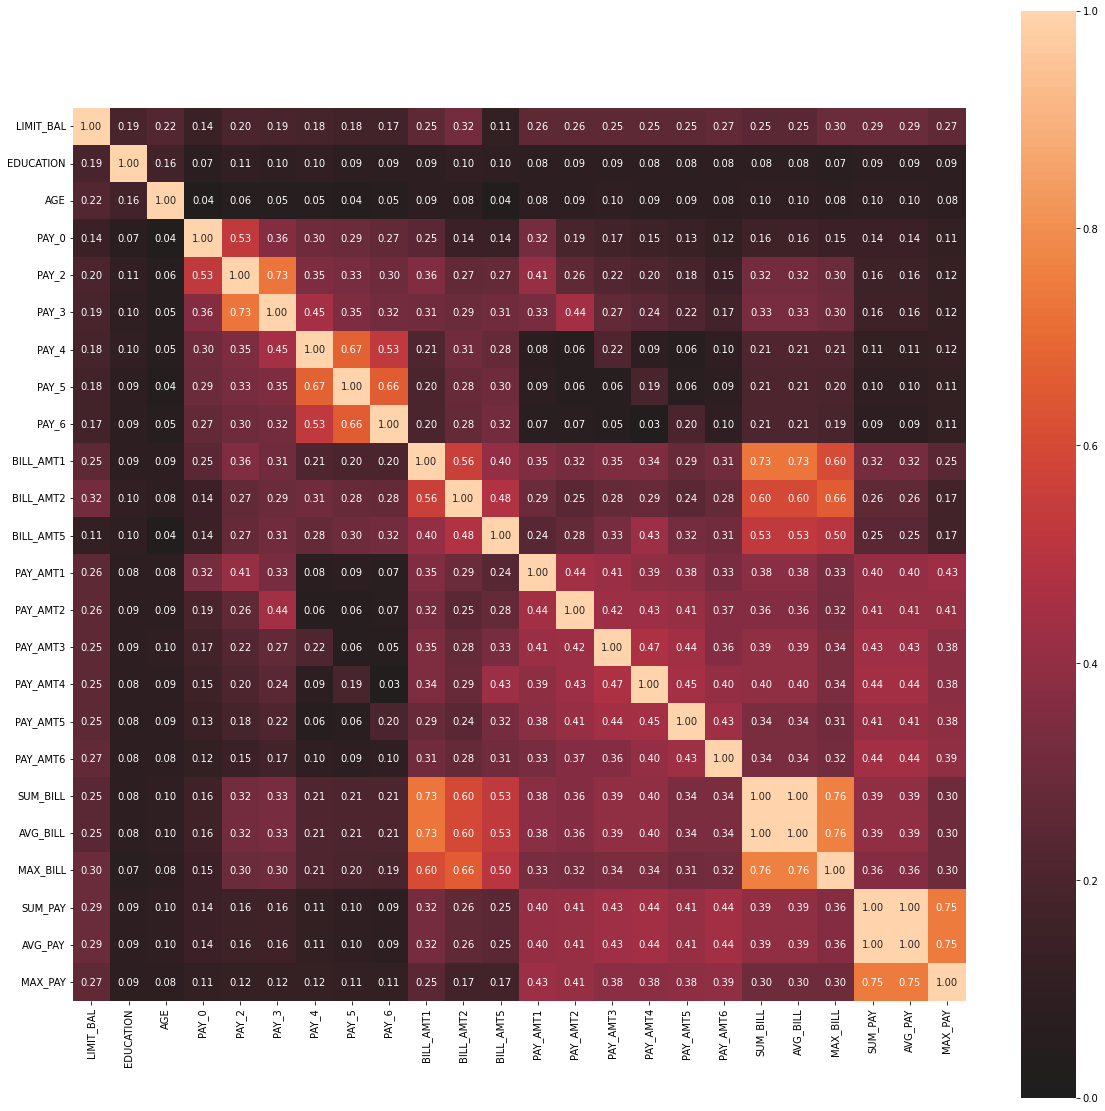

In [21]:
#realizando o cálculo de crammer com as variáveis filtradas e exibindo em formato de gráfco
z = nominal.associations(x_train_transf[filter1], nominal_columns='all', figsize=(20,20))

In [ ]:
#Nesse ponto transformamos o gráfico acima e csv salvamos nno pasta do projeto e abrimos o arquivo para analisar
#nas correlações. Retiramos as correlações acima de 60% Nass variáveis correlacionadas excluiremos as que tiverem menor iV
z['corr'].to_csv('/content/drive/MyDrive/projeto_creditscore/Curso/aula6/crammer.csv')

In [22]:
#Dentro da variável finalista, vinculamos apenas aas variáveis fruto da analise acima
finalistas = ['const','LIMIT_BAL',	'EDUCATION',	'AGE',	'PAY_0',	'PAY_2',	'PAY_5',	'BILL_AMT2',	'BILL_AMT5',	'PAY_AMT1',	'PAY_AMT2',	'PAY_AMT3',	'PAY_AMT4',	'PAY_AMT5',	'PAY_AMT6',	'AVG_BILL',	'AVG_PAY']

In [23]:
log_reg = sm.Logit(y_train, x_train_trat[finalistas]).fit()

ValueError: ignored